## 1-Import Library

In [1]:
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# scikit-learn library model selection & preprocess
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Encoder
from sklearn.preprocessing import OneHotEncoder

# scikit-learn library model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# for model evaluation
from sklearn.metrics import classification_report, f1_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy

nlp = spacy.blank("id")
nlp.add_pipe("lemmatizer", config={"mode": "lookup"})
nlp.initialize()

import jupyter_black

# Black Formatter
jupyter_black.load()

import warnings

warnings.filterwarnings("ignore")

In [2]:
def html_to_text(html):
    # Convert HTML to text using BeautifulSoup
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text()


def remove_baca_juga(text):
    # Split the text into lines
    lines = text.split("\n")
    # Remove lines containing "Baca juga"
    cleaned_lines = [line for line in lines if "Baca juga" not in line]
    # Join the cleaned lines back into text
    cleaned_text = "\n".join(cleaned_lines)
    return cleaned_text


def remove_intro_tag(text):
    # Define the regular expression pattern to match the specified format
    pattern = r"\b(?:\w+\,\s+)?KOMPAS\.com\s+\-\s+"
    # Use the re.sub() function to remove the matched pattern and the text before it
    text = re.sub(pattern, "", text)
    return text


def remove_punctuations(text):
    # Define the regular expression pattern to match punctuations
    punct_tag = re.compile(r"[^\w\s]")
    # Use the re.sub() function to remove the punctuations from the text
    text = punct_tag.sub(r"", text)
    return text


def tokenize_text(text):
    # Tokenize the text with NLTK
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens


def remove_stopwords(tokens):
    # Remove stopwords from the tokens with NLTK
    stop_words = set(stopwords.words("indonesian"))
    filtered_tokens = [word for word in tokens if not word in stop_words]
    return filtered_tokens


def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize each token in the document
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens


def remove_duplicates(tokens):
    # Remove duplicates from the tokens
    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)
    return unique_tokens


def preprocess_text(text):
    # Preprocess the text using the defined functions
    text = html_to_text(html=text)
    document = remove_baca_juga(text=text)
    document = remove_intro_tag(text=document)
    document = remove_punctuations(text=document)
    tokens = tokenize_text(text=document.lower())
    tokens = remove_stopwords(tokens)

    # Lemmatization
    tokens = lemmatize_text(text=" ".join(tokens))
    return " ".join(tokens)

## 2-Data Loading

In [3]:
# File path
file_path = "../data/Kompas.pickle"

# Open the file in read mode
with open(file_path, "rb") as file:
    # Load the data from the pickle file
    data = pickle.load(file)

In [4]:
# List to store DataFrames
dfs = []

# Loop through each set of data
for d in data:
    # Convert data to DataFrame
    df = pd.DataFrame(d)
    # Append DataFrame to list
    dfs.append(df)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

df.head()

,Url,SiteID,SiteName,SectionID,SectionName,PublishedBy,SupTitle,Title,SubTitle,Description,...,SourceName,Video,EmbedSocial,Tag,Lipsus,Related,Keyword,Content,UrlShort,PublishedDate
0,http://regional.kompas.com/read/2024/01/01/000...,1,NEWS,2,Regional,Irfan Maullana,,"Malam Tahun Baru 2024, Jokowi Jajan Telur Gulu...",,Presiden Joko Widodo (Jokowi) jajan telur gulu...,...,None,[],[],"[Jokowi, Night Market Ngarsopuro, tahun baru 2...",[],[],,"<p><!--img.1--></p>\n<p><strong>SOLO, KOMPAS.c...",http://kmp.im/AGFmTo,2024-01-01 00:06:00
1,http://nasional.kompas.com/read/2024/01/01/001...,1,NEWS,1,Nasional,Irfan Maullana,,"Panglima TNI dan Kapolri Gelar Vicon, Pastikan...",,Agus juga memerintahkan kepada para pangdam da...,...,None,[],[],"[kapolri jenderal listyo sigit prabowo, tahun ...",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTp,2024-01-01 00:16:14
2,http://megapolitan.kompas.com/read/2024/01/01/...,1,NEWS,10,Megapolitan,Irfan Maullana,,"Sapa Warga di Monas Jelang Tahun Baru 2024, He...",,Penjabat (Pj) Gubernur DKI Jakarta Heru Budi H...,...,None,[],[],"[Heru Budi, tahun baru 2024]",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTr,2024-01-01 00:26:27
3,http://regional.kompas.com/read/2024/01/01/004...,1,NEWS,2,Regional,Irfan Maullana,,"Gempa Sumedang, 53 Rumah Rusak dan 3 Korban Lu...",,"Sedikitnya 53 rumah rusak, dan tiga korban luk...",...,None,[],[],"[gempa sumedang, analisis gempa Sumedang]",[],[],,"<p><!--img.1--></p>\n<p><strong>SUMEDANG, KOMP...",http://kmp.im/AGFmTs,2024-01-01 00:43:27
4,http://megapolitan.kompas.com/read/2024/01/01/...,1,NEWS,10,Megapolitan,Irfan Maullana,,Sorak-sorai Lengkapi Kemeriahan Pesta Kembang ...,,Mereka berteriak girang karena kembang api yan...,...,None,[],[],"[Ancol, tahun baru 2024]",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTt,2024-01-01 00:49:34


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24861 entries, 0 to 24860
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Url            24861 non-null  object
 1   SiteID         24861 non-null  object
 2   SiteName       24861 non-null  object
 3   SectionID      24861 non-null  object
 4   SectionName    24861 non-null  object
 5   PublishedBy    24861 non-null  object
 6   SupTitle       24861 non-null  object
 7   Title          24861 non-null  object
 8   SubTitle       24859 non-null  object
 9   Description    24861 non-null  object
 10  AuthorName     22776 non-null  object
 11  AuthorID       22776 non-null  object
 12  Photo          24861 non-null  object
 13  SourceName     4561 non-null   object
 14  Video          24861 non-null  object
 15  EmbedSocial    24861 non-null  object
 16  Tag            24833 non-null  object
 17  Lipsus         24861 non-null  object
 18  Related        24861 non-n

In [6]:
# df["Date"] = pd.to_datetime(df["PublishedDate"]).dt.date

In [7]:
# df.describe(include="O").T

## 3-Preprocessing

### 1.Data Cleaning

In [8]:
# Remove SiteName with less than 2 data
counts = df["SiteName"].value_counts()
df = df[df["SiteName"].isin(counts[counts > 1].index)]

# Remove Content with empty value
df = df[df["Content"] != ""]

df.head()

,Url,SiteID,SiteName,SectionID,SectionName,PublishedBy,SupTitle,Title,SubTitle,Description,...,SourceName,Video,EmbedSocial,Tag,Lipsus,Related,Keyword,Content,UrlShort,PublishedDate
0,http://regional.kompas.com/read/2024/01/01/000...,1,NEWS,2,Regional,Irfan Maullana,,"Malam Tahun Baru 2024, Jokowi Jajan Telur Gulu...",,Presiden Joko Widodo (Jokowi) jajan telur gulu...,...,None,[],[],"[Jokowi, Night Market Ngarsopuro, tahun baru 2...",[],[],,"<p><!--img.1--></p>\n<p><strong>SOLO, KOMPAS.c...",http://kmp.im/AGFmTo,2024-01-01 00:06:00
1,http://nasional.kompas.com/read/2024/01/01/001...,1,NEWS,1,Nasional,Irfan Maullana,,"Panglima TNI dan Kapolri Gelar Vicon, Pastikan...",,Agus juga memerintahkan kepada para pangdam da...,...,None,[],[],"[kapolri jenderal listyo sigit prabowo, tahun ...",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTp,2024-01-01 00:16:14
2,http://megapolitan.kompas.com/read/2024/01/01/...,1,NEWS,10,Megapolitan,Irfan Maullana,,"Sapa Warga di Monas Jelang Tahun Baru 2024, He...",,Penjabat (Pj) Gubernur DKI Jakarta Heru Budi H...,...,None,[],[],"[Heru Budi, tahun baru 2024]",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTr,2024-01-01 00:26:27
3,http://regional.kompas.com/read/2024/01/01/004...,1,NEWS,2,Regional,Irfan Maullana,,"Gempa Sumedang, 53 Rumah Rusak dan 3 Korban Lu...",,"Sedikitnya 53 rumah rusak, dan tiga korban luk...",...,None,[],[],"[gempa sumedang, analisis gempa Sumedang]",[],[],,"<p><!--img.1--></p>\n<p><strong>SUMEDANG, KOMP...",http://kmp.im/AGFmTs,2024-01-01 00:43:27
4,http://megapolitan.kompas.com/read/2024/01/01/...,1,NEWS,10,Megapolitan,Irfan Maullana,,Sorak-sorai Lengkapi Kemeriahan Pesta Kembang ...,,Mereka berteriak girang karena kembang api yan...,...,None,[],[],"[Ancol, tahun baru 2024]",[],[],,<p><strong><!--img.1--></strong></p>\n<p><stro...,http://kmp.im/AGFmTt,2024-01-01 00:49:34


Before we move ahead , let us clean the dataset and remove the redundancies.This includes

- HTML codes
- Recomendation URLs (marked by "Baca juga: ...")
- Stopwords
- Punctuations

#### EXAMPLE

- Before

In [9]:
print(df["Content"].iloc[0])

<p><!--img.1--></p>
<p><strong>SOLO, KOMPAS.com</strong> - Presiden Joko Widodo (Jokowi) jajan telur gulung di "Night Market Ngarsopuro", Kota Solo, Jawa Tengah (Jateng).</p>
<p>Pantuan <em>Komapas.com</em>, Presiden Jokowi menyapa warga dan pedagang saat berkunjung ke <em>car free night</em> (CFN), Minggu (31/12/2023).</p>
<p>Kepala Negara sempat berbincang dengan pedagang UMKM di Kawasan Wisata Malam Kota Bengawan.</p>
<p>Mantan Wali Kota Solo ini tampak membeli telur gulung, tahu gejrot dan jajanan lain.</p>
<p><strong>Baca juga: <a href="http://regional.kompas.com/read/2023/12/31/224214078/jokowi-datangi-lokasi-car-free-night-di-solo-pada-malam-pergantian-tahun" target="_self">Jokowi Datangi Lokasi Car Free Night di Solo pada Malam Pergantian Tahun</a></strong></p>
<p>"Tadi beli dua <em>cup</em> telur gulung harga Rp 15.000, totalnya Rp 30.000. Dikasih, uang Rp 150.000," kata Pedagang Telur Gulung, Dimas Pranoto.</p>
<p>Selain menyapa warga, Presiden juga tampak membagikan kaus hit

In [10]:
# Preprocess text
df["Content"] = df["Content"].apply(preprocess_text)

- After

In [11]:
print(df["Content"].iloc[0])

presiden joko widodo jokowi jajan telur gulung night market ngarsopuro kota solo jawa jateng pantuan komapascom presiden jokowi sapa warga dagang kunjung car free night cfn minggu 31122023 kepala negara bincang dagang umkm kawasan wisata malam kota bengawan mantan wali kota solo beli telur gulung gejrot jajan beli cup telur gulung harga rp 15000 totalnya rp 30000 dikasih uang rp 150000 dagang telur gulung dimas pranoto sapa warga presiden bagi kaus hitam bersablon wajahnya kaus anakanak buku buku anak rini dwi wulandari warga sorak panggil presiden jokowi jam kepala negara jalan koridor gatot subroto ngarsopuro alhamdulillah ketemu hadap beliau senang ndak selfi video kawasan ngarsopuro digelar car free night cfn ramai raya 2024 kota solo jawa gelaran cfn 2100 wib 1 januari 2024 0100 wib dimeriahkan hibur masyarakat 11 panggung hibur panggung hibur sebar kawasan purwosari balai kota kawasan jalan jenderal sudirman raya pesta kembang api halaman balai kota solo


### 2.Split The Dataset

In [12]:
# Selecting the features and target
x = df["Content"]
y = df["SiteName"]

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [13]:
# Print the shapes of the resulting datasets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19888,) (19888,)
(4972,) (4972,)


### 3.Features Encoding

- Feature Encoding

In [14]:
# Vectorize the text data
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

- Label Encoding

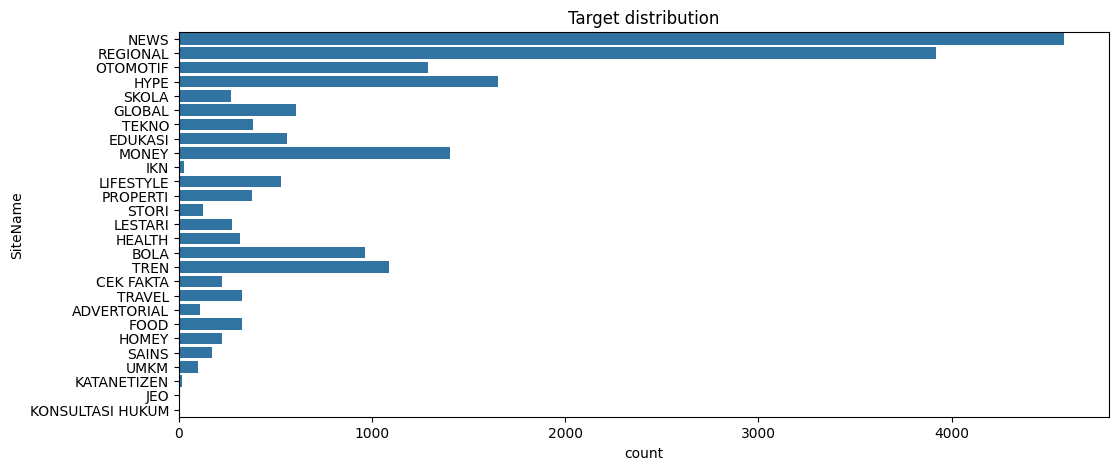

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(y_train)
plt.title("Target distribution")
plt.show()

It can be seen from Target distribution that the target class is imbalanced. This might cause issues when training the model such as overfitting and The Model might perform poorly in cases where the class is too small such as "IKN", "KATANETIZEN", "JEO", "KONSULTASI HUKUM", and etc.

In [16]:
# Assuming y_train, y_test, and y_val are pandas Series or numpy arrays
y_train_reshaped = y_train.values.reshape(-1, 1)  # Reshape for compatibility
y_test_reshaped = y_test.values.reshape(-1, 1)

# One-hot encoding
encoder = OneHotEncoder()
y_train_ohe = encoder.fit_transform(y_train_reshaped)
y_test_ohe = encoder.transform(y_test_reshaped)

In some of the machine learning models, you don't necessarily need to encode the target variable (y_train) if it consists of categorical labels. Because some of them can handle categorical labels directly.

## 4-Machine Learning Models

### 1.Logistic Regression

In [17]:
# Train a logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X_train_vec, y_train)

LogisticRegression()

In [18]:
# Evaluate the model
y_pred = model_lr.predict(X_test_vec)
y_train_pred = model_lr.predict(X_train_vec)

# Measure f1-score
print("Test set F1-score:", f1_score(y_test, y_pred, average="weighted"))

Test set F1-score: 0.8528953474369231


In [19]:
# classification report
print("Testing report------------------------")
print(classification_report(y_test, y_pred, digits=4))
print("Training report--------------------------")
print(classification_report(y_train, y_train_pred, digits=4))

Testing report------------------------
              precision    recall  f1-score   support

 ADVERTORIAL     0.7059    0.4286    0.5333        28
        BOLA     0.9793    0.9834    0.9814       241
   CEK FAKTA     0.9400    0.8393    0.8868        56
     EDUKASI     0.8971    0.8652    0.8809       141
        FOOD     0.9012    0.9012    0.9012        81
      GLOBAL     0.8188    0.8026    0.8106       152
      HEALTH     0.7945    0.7342    0.7632        79
       HOMEY     0.9259    0.8929    0.9091        56
        HYPE     0.9639    0.9685    0.9662       413
         IKN     0.4000    0.5714    0.4706         7
 KATANETIZEN     0.0000    0.0000    0.0000         5
     LESTARI     0.6441    0.5429    0.5891        70
   LIFESTYLE     0.8227    0.8788    0.8498       132
       MONEY     0.7215    0.8120    0.7641       351
        NEWS     0.8381    0.8988    0.8674      1146
    OTOMOTIF     0.9105    0.9161    0.9133       322
    PROPERTI     0.7500    0.6632    0.703

### 2.Naives Bayes

In [20]:
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

MultinomialNB()

In [21]:
# Evaluate the model
y_pred = model_nb.predict(X_test_vec)
y_train_pred = model_nb.predict(X_train_vec)

# Measure f1-score
print("Test set F1-score:", f1_score(y_test, y_pred, average="weighted"))

Test set F1-score: 0.7586655668547073


In [22]:
# Classification report
print("Testing report------------------------")
print(classification_report(y_test, y_pred, digits=4))
print("Training report--------------------------")
print(classification_report(y_train, y_train_pred, digits=4))

Testing report------------------------
              precision    recall  f1-score   support

 ADVERTORIAL     0.0000    0.0000    0.0000        28
        BOLA     0.9562    0.9959    0.9756       241
   CEK FAKTA     1.0000    0.1607    0.2769        56
     EDUKASI     0.8601    0.8723    0.8662       141
        FOOD     0.9125    0.9012    0.9068        81
      GLOBAL     0.7303    0.7303    0.7303       152
      HEALTH     0.5478    0.7975    0.6495        79
       HOMEY     0.8500    0.9107    0.8793        56
        HYPE     0.9946    0.8838    0.9359       413
         IKN     0.0000    0.0000    0.0000         7
 KATANETIZEN     0.0000    0.0000    0.0000         5
     LESTARI     0.6875    0.3143    0.4314        70
   LIFESTYLE     0.7415    0.8258    0.7814       132
       MONEY     0.5624    0.8348    0.6720       351
        NEWS     0.7468    0.8726    0.8048      1146
    OTOMOTIF     0.9253    0.8851    0.9048       322
    PROPERTI     0.8654    0.4737    0.612

### 3.Support Vector Classification

In [23]:
model_svc = SVC()
model_svc.fit(X_train_vec, y_train)

SVC()

In [24]:
# Evaluate the model
y_pred = model_svc.predict(X_test_vec)
y_train_pred = model_svc.predict(X_train_vec)

# Measure f1-score
print("Test set F1-score:", f1_score(y_test, y_pred, average="weighted"))

Test set F1-score: 0.7935631971926463


In [25]:
# Classification report
print("Testing report------------------------")
print(classification_report(y_test, y_pred, digits=4))
print("Training report--------------------------")
print(classification_report(y_train, y_train_pred, digits=4))

Testing report------------------------
              precision    recall  f1-score   support

 ADVERTORIAL     0.0000    0.0000    0.0000        28
        BOLA     0.9787    0.9544    0.9664       241
   CEK FAKTA     0.9688    0.5536    0.7045        56
     EDUKASI     0.8512    0.7305    0.7863       141
        FOOD     0.8816    0.8272    0.8535        81
      GLOBAL     0.8284    0.7303    0.7762       152
      HEALTH     0.7258    0.5696    0.6383        79
       HOMEY     0.9773    0.7679    0.8600        56
        HYPE     0.9816    0.9031    0.9407       413
         IKN     1.0000    0.1429    0.2500         7
 KATANETIZEN     0.0000    0.0000    0.0000         5
     LESTARI     0.7250    0.4143    0.5273        70
   LIFESTYLE     0.8051    0.7197    0.7600       132
       MONEY     0.6555    0.7265    0.6892       351
        NEWS     0.7879    0.8883    0.8351      1146
    OTOMOTIF     0.9226    0.8882    0.9051       322
    PROPERTI     0.7761    0.5474    0.642

## 5-Improvement to Baseline Model

All models struggle with classes having smaller supports (beacuse of Target Imbalance distribution). However, logistic regression generally handles them better than Naive Bayes and SVC. At a glance, classes like ADVERTORIAL, IKN, KATANETIZEN, and others with low support show poor performance in Naive Bayes and SVC, while logistic regression shows better results.

In terms of f1-score and handling class imbalances, Logistic Regression and SVC generally perform better than Naive Bayes. However, since Logistic Regression is the simplest model out of the trainned models and considering the computational resource needed to train and tune, I decided to try improving or tuning the Logistic Regression Model.

We'll use the TF-IDF Vectorizer as our vectorizer this time. Since TF-IDF assigns weights to words based on how often they appear in a document, and how rare they are across all documents. This helps to highlight words that are more informative and distinctive. So, I think this vectorizer is more suited for this project.

In [26]:
# Vectorize the text data
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [27]:
# Train a new logistic regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_vec, y_train)

LogisticRegression()

In [28]:
# Define the hyperparameters to tune
params = {
    "C": [
        0.1,
        10,
        30,
    ],  # Inverse of regularization strength (smaller values specify stronger regularization)
    "penalty": ["l2"],  # L1 (Lasso) or L2 (Ridge) regularization
}

random_search = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=params,
    n_iter=9,  # Number of random samples
    cv=3,  # Number of cross-validation folds
    scoring="f1_weighted",  # Evaluation metric
    random_state=42,
)

# Perform random search on the training data
random_search.fit(X_train_vec, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

Best hyperparameters: {'penalty': 'l2', 'C': 30}


In [29]:
# Evaluate the model
y_pred = best_model.predict(X_test_vec)
y_train_pred = best_model.predict(X_train_vec)

# Measure f1-score
print("Test set F1-score:", f1_score(y_test, y_pred, average="weighted"))

Test set F1-score: 0.852288778247936


In [30]:
# Classification report
print("Testing report------------------------")
print(classification_report(y_test, y_pred, digits=4))
print("Training report--------------------------")
print(classification_report(y_train, y_train_pred, digits=4))

Testing report------------------------
              precision    recall  f1-score   support

 ADVERTORIAL     0.6429    0.3214    0.4286        28
        BOLA     0.9756    0.9959    0.9856       241
   CEK FAKTA     0.9565    0.7857    0.8627        56
     EDUKASI     0.9091    0.8511    0.8791       141
        FOOD     0.8488    0.9012    0.8743        81
      GLOBAL     0.8311    0.8092    0.8200       152
      HEALTH     0.7778    0.7089    0.7417        79
       HOMEY     0.8621    0.8929    0.8772        56
        HYPE     0.9733    0.9709    0.9721       413
         IKN     0.4444    0.5714    0.5000         7
 KATANETIZEN     0.0000    0.0000    0.0000         5
     LESTARI     0.6094    0.5571    0.5821        70
   LIFESTYLE     0.7877    0.8712    0.8273       132
       MONEY     0.7461    0.8120    0.7776       351
        NEWS     0.8491    0.9180    0.8822      1146
    OTOMOTIF     0.9110    0.9224    0.9167       322
    PROPERTI     0.8025    0.6842    0.738

## 6-Saving Model

### Create the pipeline

In [61]:
# Logistic Regression Pipeline
prep_pipe = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(penalty="l2", C=30),
)

# Training
prep_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(C=30))])

In [62]:
# Evaluation
y_pred = prep_pipe.predict(X_test)
print("Test set F1-score:", f1_score(y_test, y_pred, average="weighted"))

Test set F1-score: 0.852288778247936


In [63]:
with open("../model/sitename_classification.pkl", "wb") as model_file:
    pickle.dump(prep_pipe, model_file)

## 7-Model Inference

In [64]:
with open("../model/sitename_classification.pkl", "rb") as f:
    model_pipeline = pickle.load(f)

Here, I copy part of the text from an article Kompas.com site name "News", here [Article Link](https://nasional.kompas.com/read/2024/04/14/18170951/kakorlantas-ungkap-titik-rawan-kepadatan-saat-arus-balik-lebaran-2024) to test the trained model performance on unseen text/article.


In [65]:
article = """
JAKARTA, KOMPAS.com - Kepala Korps Lalu Lintas (Kakorlantas) Polri Irjen Aan Suhanan mengungkapkan beberapa titik rawan kepadatan selama masa arus balik Lebaran 2024. 
Menurut Aan, titik rawan macet di area jalan tol biasanya terjadi di sekitar rest area. Salah satunya adalah rest area di ruas Km 456 Tol Transjawa. 
"Di Semarang itu, di tol ada di Km 456 rest area di situ memang kapasitasnya kecil. Di situ dan tadi pagi, kemarin di rest area itu lah sumbernya sehingga kita melakukan one way lokal," kata Aan di Km 29 Tol Jakarta Cikampek, Jawa Barat, Minggu (14/4/2024). 
"Di rest area lain juga masih sama di tol masih menjadi titik perlambatan," ujarnya lagi. Baca juga: Contraflow Tetap Ada Saat Arus Balik, Korlantas Siapkan Pengawalan Safety Car dan Lampu Pembatas Selain itu, Aan juga mencatat titik potensi rawan macet yang ada di sejumlah jalur arteri. 
Di Jawa Tengah, salah satu titik rawan macet ada di wilayah Pejagan dan Banyumas. "Di arteri kita bicara arteri tengah dulu Jawa Tengah, Pejagan, Banyumas Pejagan masih menjadi titik rawan macet di situ ya," kata Aan. 
Di Jawa Barat, titik yang rawan macet ada di sekitar Nagreg, Bandung; jalur Gentong, Tasikmalaya; hingga Malangbong dan Limbangan, Garut.
"""

In [66]:
model_pipeline

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(C=30))])

In [70]:
# Create a pandas DataFrame
df_inf = pd.DataFrame({"Content": [article]})

# Display the DataFrame
df_inf["Content"]

0    \nJAKARTA, KOMPAS.com - Kepala Korps Lalu Lint...
Name: Content, dtype: object

In [79]:
# Preprocess the text
df_inf["Content"] = df_inf["Content"].apply(preprocess_text)

# Evaluation
y_pred_inf = model_pipeline.predict(df_inf)

In [80]:
print(y_pred_inf[0])

NEWS


The trained model is capable of predicting the site name of the article. This is an expected outcome given that the model excels in categorizing articles into classes such as "NEWS", "REGIONAL", and some other classes with sufficient data in training set.